Import required libraries

In [ ]:
import pandas as pd
import numpy as np

import re
import nltk
nltk.download('popular')
from nltk import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

from keras.layers import Activation, Dense, Input, Subtract, Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, TensorBoard

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

Import Huffington Post dataset with keywords added from prior step of all articles with their category, link, date of publication and the list of associated key phrases

In [ ]:
df = pd.read_csv('/content/News_Category.csv', converters={'key_words': eval})
df.drop(axis=1, labels=['headline', 'authors','short_description'], inplace=True)
df.head(5)

,category,link,date,key_words
0,CRIME,https://www.huffingtonpost.com/entry/troy-new-...,2017-12-26,[dewolf also told news 10 abc reporter lauren ...
1,CRIME,https://www.huffingtonpost.com/entry/native-am...,2017-11-17,[american civil liberties union attorney claud...
2,CRIME,https://www.huffingtonpost.com/entry/hostage-s...,2017-01-10,[tuscaloosa police department spokeswoman teen...
3,CRIME,https://www.huffingtonpost.com/entry/cocaine-c...,2015-09-04,[crime]
4,CRIME,https://www.huffingtonpost.com/entry/massachus...,2016-05-23,"[local television news outlets showed dozens, ..."


Producing a list of stop words to remove from keywords list with punctuation and white spaces removed

In [ ]:
stopwords = stopwords.words("english")
for i in range(0, len(stopwords)):
  stopwords[i] = re.sub("[^\w\s]", "", stopwords[i])

Creating sets of ages of articles from publication date, word counts of keyword phrases list of all phrases, count of keyword phrases and appending them to the dataset for each respective article. Also creating an inverse index on each word occuring in the keywords list. Each word is a key in a dictionary with the values being dictionaries with keys of the article that the word appears in and the values of that dictionary being a list of positions the word appears in the keywords list for each article. This allows the articles containing a specific word from a query to be found quickly to make a list of all related articles to the query. 

In [ ]:
ages = []
word_count = []
phrase_count = []
lemma = WordNetLemmatizer()
inverted_index = {}
for doc in range(0, len(df.key_words)):
  ages.append(2020 - int(df.date[doc][0:4]))
  phrase_count.append(len(df.key_words[doc]))
  keywords = " ".join(df.key_words[doc]).lower()
  words = word_tokenize(re.sub("[^\w\s]", "", keywords))
  word_count.append(len(words))
  for pos in range(0, len(words)):
    if words[pos] not in stopwords and words[pos].isalpha():
      word = lemma.lemmatize(words[pos])
      if inverted_index.get(word) is None:
        doc_dict = {}
        doc_dict[doc] = [pos]
        inverted_index[word] = doc_dict
      else:
        if inverted_index[word].get(doc) is None:
          inverted_index[word][doc] = [pos]
        else:
          pos_list = inverted_index[word][doc]
          pos_list.append(pos)
          inverted_index[word][doc] = pos_list
          
df["ages"] = ages
df["key_word_count"] = word_count
df["key_phase_count"] = phrase_count
df.head(5)

,category,link,date,key_words,ages,key_word_count,key_phase_count
0,CRIME,https://www.huffingtonpost.com/entry/troy-new-...,2017-12-26,[dewolf also told news 10 abc reporter lauren ...,3,76,20
1,CRIME,https://www.huffingtonpost.com/entry/native-am...,2017-11-17,[american civil liberties union attorney claud...,3,90,20
2,CRIME,https://www.huffingtonpost.com/entry/hostage-s...,2017-01-10,[tuscaloosa police department spokeswoman teen...,3,51,20
3,CRIME,https://www.huffingtonpost.com/entry/cocaine-c...,2015-09-04,[crime],5,1,1
4,CRIME,https://www.huffingtonpost.com/entry/massachus...,2016-05-23,"[local television news outlets showed dozens, ...",4,65,20


This function takes in a list of words in a user entered query and forms a dictionary of all articles containing a word from the query and its associated count of occurrences of words in the query also contained in the article by using the inverted index from the previous step. It is also determining the amount of similarity of the query to the words occurring in the keyword phrases for each article. For example, if the query was "Black Lives Matters" and a phrase in the keywords is also "Black Lives Matters" then there is 100% match in addition this would be increment the complete match count that is also being collected. If this phrase occurs multiple times, then the complete count would be incremented for each time there is a complete match. If the keyword phrases only matches to "Days of Our Lives", there would only be a 33% match and the complete count would not be increased. The dictionary of related articles is then sorted by the amount of occurences of words in each article and all three of these counts are returned.

In [ ]:
def run_search(search):
  results = {}
  positions = {}
  for word in search:
    if inverted_index.get(word) is not None:
      for doc in inverted_index[word]:
        if doc not in results:
          results[doc] = len(inverted_index[word][doc])
          positions[doc] = [inverted_index[word][doc]]
        else:
          results[doc] = results[doc] + len(inverted_index[word][doc])
          positions[doc].append(inverted_index[word][doc])

  p_match = {}
  complete ={}
  search_len = len(search)
  for key in positions:
    position_len = len(positions[key])
    p_match[key] = position_len / search_len
    if search_len > 1:
      if position_len == search_len:
        complete_count = 0
        for pos in positions[key][0]:
          complete_match = True
          for i in range(1, position_len):
            if (pos + i) not in positions[key][i]:
              complete_match = False
              break
          complete_count += 1 if complete_match else 0
        complete[key] = complete_count
      else:
        complete[key] = 0
  sorted_results = sorted(results.items(), key=lambda item: item[1], reverse=True)
  complete_matches = complete if len(search) > 1 else p_match
  return ((sorted_results, p_match), complete_matches)

The next step is to import a dataset of previous query results to train the search engine model. The dataset contains the id, text and word count of the query; id, phrase count, article age and word count for the associated article; and the match rating, term frequency and complete match count for that article and query pairing. The match rating is how well the article reflected a desirable result to the query. An article that would be expected to be at the top of a search for a query will receive a score of 3-4 where as an unrelated article will get a 0. The match rating is used to determine the y for the model whereas the other data are all features.

In [ ]:
rank_data = pd.read_csv('/content/results_ranks.csv')
rank_data

,qid,query,doc_id,rating,tf,p_match,complete_count,key_size,phrase_count,search_size,doc_age
0,1,Trumps tax returns,2371,2,11,0.333333,0,79,20,3,4
1,1,Trumps tax returns,5481,2,10,0.666667,0,69,20,3,4
2,1,Trumps tax returns,4324,2,9,0.333333,0,69,20,3,5
3,1,Trumps tax returns,2271,3,8,0.666667,0,52,20,3,3
4,1,Trumps tax returns,6437,2,8,0.333333,0,85,20,3,4
...,...,...,...,...,...,...,...,...,...,...,...
175,9,walmart gift cards,8895,0,4,0.333333,0,65,20,3,3
176,9,walmart gift cards,6083,0,2,0.333333,0,54,20,3,3
177,9,walmart gift cards,2906,0,2,0.333333,0,54,20,3,3
178,9,walmart gift cards,17892,3,2,0.666667,0,8,3,3,7


Next I randomly split the data in half to create pairings since the model requires pairing to train. The model gives a relative comparison of 2 query results to determine how much more a result should be ranked higher in a list of results than another.

In [ ]:
ranking1, ranking2 = train_test_split(rank_data, test_size=0.5)
ranking1.shape, ranking2.shape

((90, 11), (90, 11))

Then we find the difference between each pairing's match rating to provide a y to the model.

In [ ]:
rank_diff = {"diff": []}
for i in range(0, len(ranking1.rating)):
  rank_diff["diff"].append(ranking1.iloc[i].rating - ranking2.iloc[i].rating)

rank_diff_data = pd.DataFrame(rank_diff, columns=rank_diff.keys())
rank_diff_data.describe()

,diff
count,90.000000
mean,0.333333
std,1.854239
min,-4.000000
25%,-1.000000
50%,0.000000
75%,2.000000
max,4.000000


Next, I drop any columns that will not be used by the model for training.

In [ ]:
ranking1.drop(columns=['rating', 'qid', 'query', 'doc_id'], inplace=True)
ranking2.drop(columns=['rating', 'qid', 'query', 'doc_id'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
ranking1.shape, ranking2.shape, rank_diff_data.shape

((90, 7), (90, 7), (90, 1))

The model is a Siamese-like model where it uses 2 neural networks to come up with a score that is then passed to another network to find the difference between the 2 networks and use a sigmoidal activation function to determine the relative ranking for the pairing.

In [ ]:
def create_base_model(input_shape):
  model = Sequential()
  model.add(Dense(64, input_shape=input_shape, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
def create_conjoined_model(input_shape, base_model):
  input_a = Input(shape=(input_shape[0],input_shape[1],))
  input_b = Input(shape=(input_shape[0],input_shape[1],))

  rank_diff = Subtract()([base_model(input_a), base_model(input_b)])
  output = Activation("sigmoid")(rank_diff)
  model = Model(inputs = [input_a, input_b], outputs = output)
  model.compile(optimizer="adam", loss="binary_crossentropy", metrics='accuracy')

  return model

In [ ]:
scoring_model = create_base_model(ranking1.shape)
model = create_conjoined_model(ranking1.shape, scoring_model)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 90, 7)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 90, 7)]      0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 90, 1)        3137        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
subtract (Subtract)             (None, 90, 1)        0           sequential[0][0]      

The model trains very quickly probably due to the small dataset used in training. I have found that the model usually has the best validation accuracy around 200 epochs.

In [ ]:
history = model.fit([ranking1, ranking2], rank_diff_data, validation_split=0.1, epochs= 200, batch_size=10, verbose=1)

Epoch 1/200
9/9 [==============================] - 0s 27ms/step - loss: 0.7847 - accuracy: 0.2963 - val_loss: 0.7348 - val_accuracy: 0.3333
Epoch 2/200
9/9 [==============================] - 0s 3ms/step - loss: 0.7227 - accuracy: 0.1975 - val_loss: 0.7100 - val_accuracy: 0.3333
Epoch 3/200
9/9 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.2222 - val_loss: 0.7015 - val_accuracy: 0.2222
Epoch 4/200
9/9 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.2593 - val_loss: 0.6986 - val_accuracy: 0.3333
Epoch 5/200
9/9 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.2716 - val_loss: 0.6970 - val_accuracy: 0.3333
Epoch 6/200
9/9 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.2716 - val_loss: 0.6960 - val_accuracy: 0.3333
Epoch 7/200
9/9 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.2593 - val_loss: 0.6951 - val_accuracy: 0.3333
Epoch 8/200
9/9 [=========

By ploting the accuracies and loss, I can see how I need to change the number of epochs as the dataset grows. Since each time the application is run, it collects more data to add to the query results dataset for training.

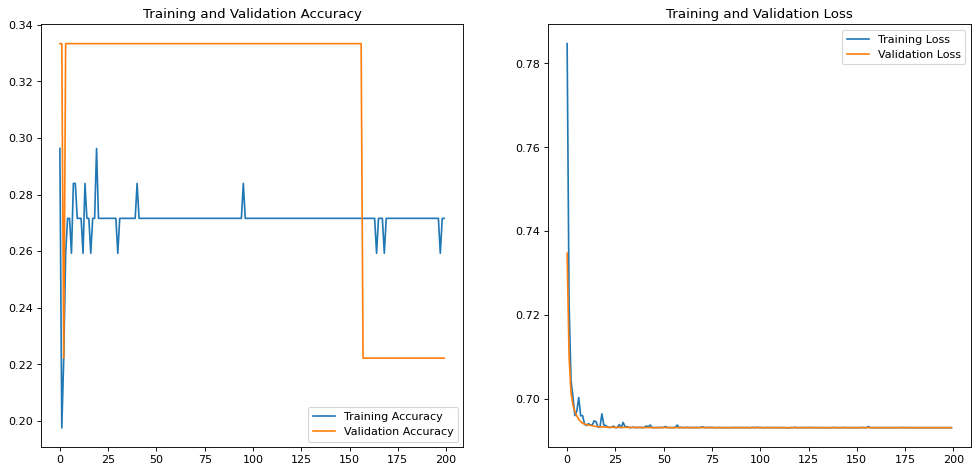

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 7), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This function uses the model to indicate which result is ranked higher than the other result.

In [ ]:
def perform_rank(result1, result2):
  rank = model.predict((np.array([result1[1:]]), np.array([result2[1:]])))
  return 1 if rank > 0.5 else (0 if rank == 0.5 else -1)

This step prompts the user if they would like to enter a query then prompts for a query. It then collects a list of all of the matching articles and associated features relating to the query, article and relationships between the query and article. It then uses the previously trained model to rank the results in order and presents the top 20 results. To increase the speed of the results, the model is only used for top 100 results for term frequency. The top 20 ranked results are then presented to the user and the user is then asked to provide a ranking for that article and query matching. All of these features are then collected for each result and made into a dataset.

In [ ]:
import functools

rating_data = {"qid": [], "query": [], "doc_id": [], "rating": [], "tf":  [], 
               "p_match": [], "complete_count": [], "key_size": [], 
               "phrase_count": [], "search_size": [], "doc_age": []}
qid = 0
while(input("Do you want a new query(y/n)? ").lower() == 'y'):
  qid += 1
  search_phrase = input("What query do you want to run? ")

  search_words = word_tokenize(re.sub("[^\w\s]", "", search_phrase.lower()))
  clean_search = []
  for word in search_words:
    if word not in stopwords and word.isalpha():
      clean_search.append(lemma.lemmatize(word))

  (result_list, match_dict), complete_dict = run_search(clean_search)
  limited_list = []
  # Use term frequency to reduce the list to the top 500 results then use ranknet
  # to increase the speed of finding the ranked results
  search_limit = 100 if len(result_list) > 100 else len(result_list)
  for idx in range(0, search_limit):
    doc = result_list[idx][0]
    # doc_id tf	p_match	complete_count	key_size	phrase_count	search_size	doc_age
    limited_list.append([doc, result_list[idx][1], match_dict[doc], 
                        complete_dict[doc], df.key_word_count[doc], 
                        df.key_phase_count[doc], len(clean_search), 
                        df.ages[doc]])
  sorted_results = sorted(limited_list, key=functools.cmp_to_key(perform_rank), reverse=True)

  for idx in range(0, 20):
    print(sorted_results[idx])
    rating = input("How do you rate the link {}".format(df.link[sorted_results[idx][0]]))
    rating_data["qid"].append(qid)
    rating_data["query"].append(search_phrase)
    rating_data["doc_id"].append(sorted_results[idx][0])
    rating_data["rating"].append(rating)
    rating_data["tf"].append(sorted_results[idx][1])
    rating_data["p_match"].append(sorted_results[idx][2])
    rating_data["complete_count"].append(sorted_results[idx][3])
    rating_data["key_size"].append(sorted_results[idx][4])
    rating_data["phrase_count"].append(sorted_results[idx][5])
    rating_data["search_size"].append(sorted_results[idx][6])
    rating_data["doc_age"].append(sorted_results[idx][7])

Do you want a new query(y/n)? y
What query do you want to run? identity theft prevention
[8104, 1, 0.3333333333333333, 0, 7, 5, 3, 3]
How do you rate the link https://www.huffingtonpost.com/entry/embracethelatinx-is-an-all-inclusive-tribute-to-latinos-many-identities_us_59514b21e4b0da2c731d7d790
[61, 6, 0.6666666666666666, 0, 103, 20, 3, 5]
How do you rate the link https://www.huffingtonpost.com/entry/5-identity-theft-facts-th_b_7347248.html4
[4286, 3, 0.3333333333333333, 0, 79, 20, 3, 4]
How do you rate the link https://www.huffingtonpost.com/entry/transbillma-making-transg_b_9161456.html0
[4377, 3, 0.3333333333333333, 0, 78, 20, 3, 4]
How do you rate the link https://www.huffingtonpost.com/entry/new-study-womens-sexual-identity_us_5755dc06e4b0ca5c7b4fca6f0
[6562, 3, 1.0, 1, 67, 20, 3, 6]
How do you rate the link https://www.huffingtonpost.com/entry/heartbleed-free-tool-to-c_us_5bb370fae4b0fa920b98f8793
[8093, 3, 0.3333333333333333, 0, 70, 20, 3, 4]
How do you rate the link https://ww

In [ ]:
data = pd.DataFrame(rating_data, columns=rating_data.keys())

The following computes the Normalized Cumulative Discounted Gain for the results list based on the ratings provided by the user and the position in the list the ranking occurs. Rankings at the top of the list increase the score more than those at the bottom and these scores for each result are then summed, which is the Discounted Cumulative Gain(DCG) part. Then the scores are normalized by comparing an ideal order of the results to the actual results by taking the list of results and sorting by rating and calculating the DCG. If the results are ordered ideally, then the score is 1.0.

In [ ]:
import math

def get_DCG(array):
  DCG = 0

  for i in range(0, len(array)):
    DCG += array[i] / math.log(i + 2, 2)

  return DCG

In [ ]:
rank_array = data['rating'].astype('int32').tolist()
get_DCG(rank_array) / get_DCG(sorted(rank_array, reverse=True))

0.5704743663854617

The results dataset is now appended to the previously imported dataset that was used to train the model then saved to a csv file to be used again at a later time to better train the model.

In [ ]:
max_id = rank_data["qid"].max()
for i in range(0, len(data['qid'])):
  data['qid'][i] += max_id
rank_data = rank_data.append(data, ignore_index = True)
rank_data.to_csv('results_ranks.csv', index=False)
rank_data